Robot Dynamics Model Identification
=======
---

# Praparing work

## Import libraries

In [1]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
import pickle
import os.path
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
import time

## Folder dir for saving and loading files

In [2]:
model_folder = 'data/model/'
trajectory_folder = 'data/trajectory/'
optimal_trajectory_folder = 'data/optimal_trajectory/'

---
# Robot modelling

## Create joint variables and define their relations

In [3]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9 = new_sym('q:10')
# define paralelogram coordinate relation
# q3 = -q2 + q8
# q9 = -q8 + q2

## DH definition in the order of joint_type, a, alpha, d, theta, dh_type, prev, succ

In [4]:
#robot_def = RobotDef([(0,   -1, [1],    0,      0,              0,          0),
#                      (1,   0,  [2],    0,      0,              -0.21537,   q1),
#                      (2,   1,  [3],    0,      -sympy.pi/2,    0,          q2+sympy.pi/2),
#                      (3,   2,  [4],    0.279,  0,              0,          q3 + sympy.pi / 2)],
#                     dh_convention='mdh',
#                     friction_type=['Coulomb', 'viscous', 'offset'])

robot_def = RobotDef([(0,   -1, [1],    0,      0,              0,          0),
                      (1,   0,  [2],    0,      0,              -0.21537,   q1),
                      (2,   1,  [3],    0,      -sympy.pi/2,    0,          q2+sympy.pi/2),
                      (3,   2,  [4],    0.279,  0,              0,          q3 + sympy.pi / 2)],
                     dh_convention='mdh',
                     friction_type=[])

[q1, q2, q3]


In [5]:
robot_def.m

## Create kinematics chain

In [6]:
geom = Geometry(robot_def)


pos_c1
v_cw1
dR_t1
subs dq1
w_b
pos_c2
v_cw2
dR_t2
subs dq2
w_b
pos_c3
v_cw3
dR_t3
subs dq3
w_b
pos_c
[0, Matrix([
[l1x*cos(q1)/m1 - l1y*sin(q1)/m1],
[l1x*sin(q1)/m1 + l1y*cos(q1)/m1],
[               l1z/m1 - 0.21537]]), Matrix([
[-l2x*sin(q2)*cos(q1)/m2 - l2y*cos(q1)*cos(q2)/m2 - l2z*sin(q1)/m2],
[-l2x*sin(q1)*sin(q2)/m2 - l2y*sin(q1)*cos(q2)/m2 + l2z*cos(q1)/m2],
[                       -l2x*cos(q2)/m2 + l2y*sin(q2)/m2 - 0.21537]]), Matrix([
[l3x*(sin(q2)*sin(q3)*cos(q1) - cos(q1)*cos(q2)*cos(q3))/m3 + l3y*(sin(q2)*cos(q1)*cos(q3) + sin(q3)*cos(q1)*cos(q2))/m3 - l3z*sin(q1)/m3 - 0.279*sin(q2)*cos(q1)],
[l3x*(sin(q1)*sin(q2)*sin(q3) - sin(q1)*cos(q2)*cos(q3))/m3 + l3y*(sin(q1)*sin(q2)*cos(q3) + sin(q1)*sin(q3)*cos(q2))/m3 + l3z*cos(q1)/m3 - 0.279*sin(q1)*sin(q2)],
[                                              l3x*(sin(q2)*cos(q3) + sin(q3)*cos(q2))/m3 + l3y*(-sin(q2)*sin(q3) + cos(q2)*cos(q3))/m3 - 0.279*cos(q2) - 0.21537]])]
v_cw
[0, Matrix([
[-dq1*(l1x*sin(q1) + l1y*cos(q1))/m1],


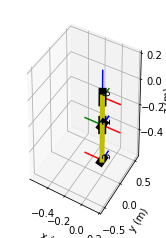

In [7]:
geom.draw_geom()

## Create dynamics object


In [8]:
dyn = Dynamics(robot_def, geom)


('k_e:', L1zz*dq1**2/2)
('k_e:', L2xx*dq1**2*cos(2*q2)/4 + L2xx*dq1**2/4 - L2xy*dq1**2*sin(2*q2)/2 - L2xz*dq1*dq2*cos(q2) - L2yy*dq1**2*cos(2*q2)/4 + L2yy*dq1**2/4 + L2yz*dq1*dq2*sin(q2) + L2zz*dq2**2/2)
('k_e:', -0.25*L3xx*dq1**2*cos(2*q2 + 2*q3) + 0.25*L3xx*dq1**2 + 0.5*L3xy*dq1**2*sin(2*q2 + 2*q3) + 1.0*L3xz*dq1*dq2*sin(q2 + q3) + 1.0*L3xz*dq1*dq3*sin(q2 + q3) + 0.25*L3yy*dq1**2*cos(2*q2 + 2*q3) + 0.25*L3yy*dq1**2 + 1.0*L3yz*dq1*dq2*cos(q2 + q3) + 1.0*L3yz*dq1*dq3*cos(q2 + q3) + 0.5*L3zz*dq2**2 + 1.0*L3zz*dq2*dq3 + 0.5*L3zz*dq3**2 - 0.1395*dq1**2*l3x*sin(q3) + 0.1395*dq1**2*l3x*sin(2*q2 + q3) - 0.1395*dq1**2*l3y*cos(q3) + 0.1395*dq1**2*l3y*cos(2*q2 + q3) - 0.01946025*dq1**2*m3*cos(2*q2) + 0.01946025*dq1**2*m3 + 0.279*dq1*dq2*l3z*cos(q2) - 0.279*dq2**2*l3x*sin(q3) - 0.279*dq2**2*l3y*cos(q3) + 0.0389205*dq2**2*m3 - 0.279*dq2*dq3*l3x*sin(q3) - 0.279*dq2*dq3*l3y*cos(q3))
3
dk_ddq_dtt:
L1zz*Derivative(q1t(t), (t, 2)) - L2xx*sin(2*q2t(t))*Derivative(q1t(t), t)*Derivative(q2t(t), t) + L2xx

tau: 
[L1zz*ddq1 + L2xx*ddq1*cos(2*q2)/2 + L2xx*ddq1/2 - L2xx*dq1*dq2*sin(2*q2) - L2xy*ddq1*sin(2*q2) - 2*L2xy*dq1*dq2*cos(2*q2) - L2xz*ddq2*cos(q2) + L2xz*dq2**2*sin(q2) - L2yy*ddq1*cos(2*q2)/2 + L2yy*ddq1/2 + L2yy*dq1*dq2*sin(2*q2) + L2yz*ddq2*sin(q2) + L2yz*dq2**2*cos(q2) - 0.5*L3xx*ddq1*cos(2*q2 + 2*q3) + L3xx*ddq1/2 + L3xx*dq1*(dq2 + dq3)*sin(2*q2 + 2*q3) + L3xy*ddq1*sin(2*q2 + 2*q3) + 2*L3xy*dq1*(dq2 + dq3)*cos(2*q2 + 2*q3) + L3xz*ddq2*sin(q2 + q3) + L3xz*ddq3*sin(q2 + q3) + L3xz*dq2*(dq2 + dq3)*cos(q2 + q3) + L3xz*dq3*(dq2 + dq3)*cos(q2 + q3) + L3yy*ddq1*cos(2*q2 + 2*q3)/2 + L3yy*ddq1/2 - 1.0*L3yy*dq1*(dq2 + dq3)*sin(2*q2 + 2*q3) + L3yz*ddq2*cos(q2 + q3) + L3yz*ddq3*cos(q2 + q3) - 1.0*L3yz*dq2*(dq2 + dq3)*sin(q2 + q3) - 1.0*L3yz*dq3*(dq2 + dq3)*sin(q2 + q3) - 0.279*ddq1*l3x*sin(q3) + 0.279*ddq1*l3x*sin(2*q2 + q3) - 0.279*ddq1*l3y*cos(q3) + 0.279*ddq1*l3y*cos(2*q2 + q3) - 0.0389205*ddq1*m3*cos(2*q2) + 0.0389205*ddq1*m3 + 0.279*ddq2*l3z*cos(q2) + 0.077841*dq1*dq2*m3*sin(2*q2) - 0.

Matrix([[0, 0, 0, 0, 0, ddq1, 0, 0, 0, 0, ddq1*cos(2*q2)/2 + ddq1/2 - dq1*dq2*sin(2*q2), -ddq1*sin(2*q2) - 2*dq1*dq2*cos(2*q2), -ddq2*cos(q2) + dq2**2*sin(q2), -ddq1*cos(2*q2)/2 + ddq1/2 + dq1*dq2*sin(2*q2), ddq2*sin(q2) + dq2**2*cos(q2), 0, 0, 0, 0, 0, -0.5*ddq1*cos(2*q2 + 2*q3) + ddq1/2 + dq1*(dq2 + dq3)*sin(2*q2 + 2*q3), ddq1*sin(2*q2 + 2*q3) + 2*dq1*(dq2 + dq3)*cos(2*q2 + 2*q3), ddq2*sin(q2 + q3) + ddq3*sin(q2 + q3) + dq2*(dq2 + dq3)*cos(q2 + q3) + dq3*(dq2 + dq3)*cos(q2 + q3), ddq1*cos(2*q2 + 2*q3)/2 + ddq1/2 - 1.0*dq1*(dq2 + dq3)*sin(2*q2 + 2*q3), ddq2*cos(q2 + q3) + ddq3*cos(q2 + q3) - 1.0*dq2*(dq2 + dq3)*sin(q2 + q3) - 1.0*dq3*(dq2 + dq3)*sin(q2 + q3), 0, -0.279*ddq1*sin(q3) + 0.279*ddq1*sin(2*q2 + q3) - 0.279*dq1*dq3*cos(q3) + 0.279*dq1*(2*dq2 + dq3)*cos(2*q2 + q3), -0.279*ddq1*cos(q3) + 0.279*ddq1*cos(2*q2 + q3) + 0.279*dq1*dq3*sin(q3) - 0.279*dq1*(2*dq2 + dq3)*sin(2*q2 + q3), 0.279*ddq2*cos(q2) - 0.279*dq2**2*sin(q2), -0.0389205*ddq1*cos(2*q2) + 0.0389205*ddq1 + 0.077841*dq1

---
# Excitation trajectory optimization

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [9]:
base_freq = 0.1
fourier_order = 6

traj_optimizer = TrajOptimizer(dyn, fourier_order, base_freq,
                               joint_constraints=[(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                                                  (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)])
traj_optimizer.optimize()

('joint constraint number: ', 2)
('cartisian constraint number: ', 0)
('constraint number: ', 8)

Optimization Problem -- Optimial Excitation Trajectory

        Objective Function: _obj_func

    Objectives:
        Name        Value        Optimum
	     f               0             0

	Variables (c - continuous, i - integer, d - discrete):
        Name    Type       Value       Lower Bound  Upper Bound
	     x1       c	      0.075660      -3.14e+00     3.14e+00 
	     x2       c	      0.008674      -1.00e+00     1.00e+00 
	     x3       c	      0.039375      -1.00e+00     1.00e+00 
	     x4       c	      0.083585      -1.00e+00     1.00e+00 
	     x5       c	      0.018466      -1.00e+00     1.00e+00 
	     x6       c	      0.036810      -1.00e+00     1.00e+00 
	     x7       c	      0.001667      -1.00e+00     1.00e+00 
	     x8       c	      0.098342      -1.00e+00     1.00e+00 
	     x9       c	      0.092831      -1.00e+00     1.00e+00 
	    x10       c	      0.078189      -1.00

('fstr: ', array([2.72905673]))
('xstr: ', array([-0.43088801, -0.32401528, -0.30853451, -0.99926804,  0.95415126,
       -0.99991612,  1.        ,  0.15189284,  0.19847208,  0.89909112,
       -1.        ,  0.99158857,  1.        , -0.07347386,  0.69439051,
        0.26310269, -0.19824484,  0.3297264 ,  0.78312463,  0.99999996,
        0.2457836 ,  0.14011726, -0.07901393,  0.99990202, -1.        ,
        1.        , -1.64018449,  0.66495307, -0.4888334 ,  0.97452591,
        0.99998095,  0.1335359 , -1.        ,  1.        ,  0.89461609,
       -0.26008492, -0.02720468, -0.28667669, -1.        ]))
('inform: ', {'text': 'Optimization terminated successfully.', 'value': 0})

SLSQP Solution to Optimial Excitation Trajectory

        Objective Function: _obj_func

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    8.8647
    Total Function Evaluations:          
    Sensitivities:        FD

    Objectives:


## Plot optimal excitation trajectory

('traj:', 0)
('traj:', 1)
('traj:', 2)


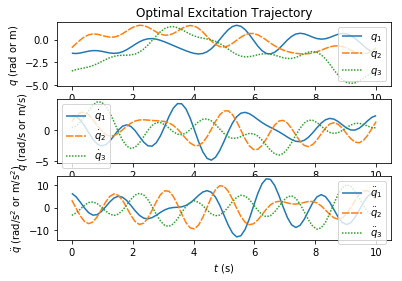

In [10]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

## Save trajectory for later use

In [11]:
dof_order_bf_x = (traj_optimizer.fourier_traj.dof, fourier_order, base_freq, traj_optimizer.x_result)


In [12]:
dof_order_bf_x_file_name = 'optimal_traj1.pkl'
dof_order_bf_x_dir = optimal_trajectory_folder + dof_order_bf_x_file_name

#if not os.path.exists(dof_order_bf_x_dir):
with open(dof_order_bf_x_dir, 'wr') as f:
    pickle.dump(dyn.H_b, f)

---
# Data processing

In [13]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

## Load data

In [14]:
trajectory_data_file = trajectory_folder + 'test.csv'
trajectory_sampling_rate = 200
t, q_raw, tau_raw = load_trajectory_data(trajectory_data_file, trajectory_sampling_rate)
dof = q_raw.shape[1]

(<type 'numpy.ndarray'>, (6000, 6))


## Calculate filter cut-off frequency

In [15]:
fc_mult = 10.0
wf = 0.1
order = 5
fc = wf * order * fc_mult
print("cut frequency is {}".format(fc))

cut frequency is 5.0


## Get velocity and acceleration data and filter raw data

q_raw shape: (6000, 3)
0
1
2
plot shape: 430


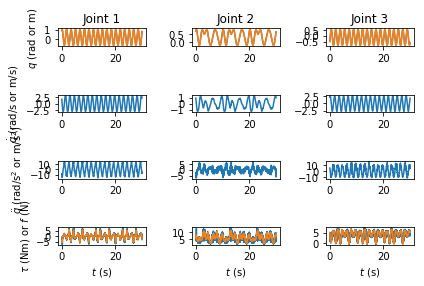

In [16]:
t_cut, q_f, dq_f, ddq_f, tau_f, q_raw_cut, tau_raw_cut = diff_and_filt_data(dof, 1.0/trajectory_sampling_rate, t,
                                                                        q_raw, tau_raw, fc, fc, fc, fc)
plot_trajectory_data(t_cut, q_raw_cut, q_f, dq_f, ddq_f, tau_raw_cut, tau_f)

In [17]:
traj_optimizer.x_result

array([-0.43088801, -0.32401528, -0.30853451, -0.99926804,  0.95415126,
       -0.99991612,  1.        ,  0.15189284,  0.19847208,  0.89909112,
       -1.        ,  0.99158857,  1.        , -0.07347386,  0.69439051,
        0.26310269, -0.19824484,  0.3297264 ,  0.78312463,  0.99999996,
        0.2457836 ,  0.14011726, -0.07901393,  0.99990202, -1.        ,
        1.        , -1.64018449,  0.66495307, -0.4888334 ,  0.97452591,
        0.99998095,  0.1335359 , -1.        ,  1.        ,  0.89461609,
       -0.26008492, -0.02720468, -0.28667669, -1.        ])

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [18]:
base_param_num = dyn.base_num
H_b_func = dyn.H_b_func
W_b, tau_s = gen_regressor(base_param_num, H_b_func, q_f, dq_f, ddq_f, tau_f)

In [19]:
print(W_b.shape, tau_s.shape)

((17970, 15), (17970,))


In [20]:
xb_ols = np.linalg.lstsq(W_b, tau_s)[0]

/home/yan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [21]:
xb_ols

array([ 4.51759594e-01, -5.50129960e-04,  7.21406441e-02, -2.03789196e-02,
        7.79418804e-04,  8.39004192e-01,  1.42708260e-02,  3.04222130e-03,
        1.04918787e-01,  1.21380433e-04, -9.80113090e-04,  1.30898057e-01,
        4.97529618e-02,  1.79097965e-01,  3.10781502e-01])

## Compare measured torque and predicted torque

### Generate predicted torque

In [22]:
tau_p = np.zeros(tau_f.shape)
tau_ps = W_b.dot(xb_ols)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof]

### Evaluate regression

In [23]:
var_regression_error_ols = np.linalg.norm(tau_ps - tau_s) / (tau_ps.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols * np.linalg.inv(W_b.transpose().dot(W_b))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.0022718597256644974
standard deviation of xb using OLS:
[8.17399761e-05 7.93194379e-05 2.06990051e-04 7.55993668e-05
 6.13950613e-05 3.92365726e-04 1.66379760e-04 1.63771907e-04
 1.70608326e-04 2.14751179e-04 1.21574894e-04 1.22162924e-04
 1.61095358e-04 4.73460573e-04 4.06769460e-04]
percentage of standard deviation of xb using OLS: 
[1.80936890e-04 1.44183091e-01 2.86925703e-03 3.70968472e-03
 7.87703106e-02 4.67656454e-04 1.16587337e-02 5.38330027e-02
 1.62609892e-03 1.76924050e+00 1.24041700e-01 9.33267662e-04
 3.23790487e-03 2.64358432e-03 1.30885994e-03]


### Plot measured torque and predicted torque

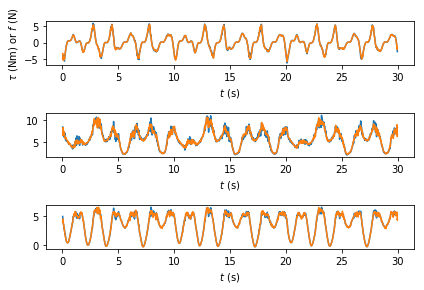

In [24]:
plot_meas_pred_tau(t_cut, tau_f, tau_p)

## Weighted Least Square (WLS)

In [25]:
robot_def.params

## Convex optimization

In [26]:
# #from identification import SDPOpt
# import cvxpy as cp

# # sdp_opt = SDPOpt(W_b, tau_s, None)
# # sdp_opt.solve()
# m, n = W_b.shape
# sdp_x = cp.Variable(n)
# sdp_obj = cp.Minimize(cp.sum_squares(W_b*sdp_x - tau_s))
# sdp_constraints = []
# sdp_prob = cp.Problem(sdp_obj, sdp_constraints)

# result = sdp_prob.solve(solver=cp.OSQP)

# print(sdp_x.value)

[ 4.51759594e-01 -5.50129960e-04  7.21406441e-02 -2.03789196e-02
  7.79418804e-04  8.39004192e-01  1.42708260e-02  3.04222130e-03
  1.04918787e-01  1.21380433e-04 -9.80113090e-04  1.30898057e-01
  4.97529618e-02  1.79097965e-01  3.10781502e-01]


In [27]:
# xb_ols

array([ 4.51759594e-01, -5.50129960e-04,  7.21406441e-02, -2.03789196e-02,
        7.79418804e-04,  8.39004192e-01,  1.42708260e-02,  3.04222130e-03,
        1.04918787e-01,  1.21380433e-04, -9.80113090e-04,  1.30898057e-01,
        4.97529618e-02,  1.79097965e-01,  3.10781502e-01])

### Generate regressor matrix for barycentric parameters

In [32]:
from identification import SDPOpt

std_param_num = len(robot_def.params)
H_func = dyn.H_func
W, tau_s = gen_regressor(std_param_num, H_func, q_f, dq_f, ddq_f, tau_f)

In [ ]:
# constraint order: (min_m, max_m, min_x, max_x, min_y, max_y, min_z, max_z)
sdp_constraints = [(1, 5, )]

In [33]:
sdp_opt_std = SDPOpt(W, tau_s, robot_def.params, robot_def.dof, sdp_constraints)
sdp_opt_std.solve()

(17970, 30)
(17970,)
[ 4.46688811e-08  0.00000000e+00  0.00000000e+00  4.46688811e-08
  0.00000000e+00  1.46001382e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  4.46688812e-08  1.46764316e-02  3.00943577e-03
  7.95046266e-05  1.33136733e-01  2.71876960e-06  6.08410897e-02
  3.31481852e-01  9.86421499e-03  5.72359404e-03  1.73772787e+03
  1.90466113e-02 -2.06537509e-02 -7.96720863e-04  1.25609570e-01
  8.16719473e-04  1.31042449e-01  4.51045561e-01  7.21166585e-02
  2.89690475e-03  1.86809041e+00]


In [38]:
sympy.Matrix(robot_def.params)

⎡L1xx⎤
⎢    ⎥
⎢L1xy⎥
⎢    ⎥
⎢L1xz⎥
⎢    ⎥
⎢L1yy⎥
⎢    ⎥
⎢L1yz⎥
⎢    ⎥
⎢L1zz⎥
⎢    ⎥
⎢l1x ⎥
⎢    ⎥
⎢l1y ⎥
⎢    ⎥
⎢l1z ⎥
⎢    ⎥
⎢ m₁ ⎥
⎢    ⎥
⎢L2xx⎥
⎢    ⎥
⎢L2xy⎥
⎢    ⎥
⎢L2xz⎥
⎢    ⎥
⎢L2yy⎥
⎢    ⎥
⎢L2yz⎥
⎢    ⎥
⎢L2zz⎥
⎢    ⎥
⎢l2x ⎥
⎢    ⎥
⎢l2y ⎥
⎢    ⎥
⎢l2z ⎥
⎢    ⎥
⎢ m₂ ⎥
⎢    ⎥
⎢L3xx⎥
⎢    ⎥
⎢L3xy⎥
⎢    ⎥
⎢L3xz⎥
⎢    ⎥
⎢L3yy⎥
⎢    ⎥
⎢L3yz⎥
⎢    ⎥
⎢L3zz⎥
⎢    ⎥
⎢l3x ⎥
⎢    ⎥
⎢l3y ⎥
⎢    ⎥
⎢l3z ⎥
⎢    ⎥
⎣ m₃ ⎦

In [35]:
from identification import barycentric2standard_params

In [36]:
sdp_opt_std.x_result

array([ 4.46688811e-08,  0.00000000e+00,  0.00000000e+00,  4.46688811e-08,
        0.00000000e+00,  1.46001382e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.46688812e-08,  1.46764316e-02,  3.00943577e-03,
        7.95046266e-05,  1.33136733e-01,  2.71876960e-06,  6.08410897e-02,
        3.31481852e-01,  9.86421499e-03,  5.72359404e-03,  1.73772787e+03,
        1.90466113e-02, -2.06537509e-02, -7.96720863e-04,  1.25609570e-01,
        8.16719473e-04,  1.31042449e-01,  4.51045561e-01,  7.21166585e-02,
        2.89690475e-03,  1.86809041e+00])

In [37]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_def.params)

([4.46688810789520e-8, 0, 0, 4.46688810789520e-8, 0, 0.0146001382491154], [0.0, 0.0, 0.0], 4.466888123516113e-08)
([0.0146763567273882, 0.00301131742401278, 8.05964360033109e-5, 0.133073482103935, 2.75125959076886e-6, 0.0607778015774950], [0.00019075590447273572, 5.676501560669202e-06, 3.2937228689418243e-06], 1737.7278744658972)
([0.0162580929228494, -0.00324137160163212, -9.72707597105524e-5, 0.0167013024616262, 0.000928552973690457, 0.0193546471151019], [0.24144739455841144, 0.0386044798682806, 0.0015507304884140177], 1.86809040597134)
